In [1]:
import numpy as np
import torch
import pandas as pd
from comet import download_model, load_from_checkpoint
from typing import List
import json
from transformers import AutoTokenizer
from matplotlib import pyplot as plt
import numpy
from mbart_qe import download_mbart_qe, load_mbart_qe

2022-08-08 11:56:24.097906: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-08 11:56:24.097932: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
mbartqe_dir = "./mbartqemodel"
mbartqe_model = "wmt21-mbart-m2"
cometqe_dir = "./cometqemodel"
cometqe_model = "wmt20-comet-qe-da"
cometmodel = "wmt20-comet-da"
batch_size = 64
def load_cands(fname):
    data = []
    with open(fname, 'r') as file:
        while True:
            line = file.readline()
            #print(line)
            # if line is empty
            # end of file is reached
            if not line or len(line)<3:
                break

            data.append(json.loads(line))
    return data

def process_cands(cand_data):
    refs = []
    hyps = []
    srcs = []
    clen = len(cand_data['scores'])
    # return refs, hyps, srcs
    return [cand_data['ref']]*clen, cand_data['cands'], [cand_data['inp']]*clen
        

def get_average_score(cand_data, resco):
    scoresum = 0
    scoretot = 0
    s = "scores"
    if resco:
        s = "rescores"
    for c in cand_data:
        scoresum+=sum(c[s])
        scoretot+=len(c[s])
    return scoresum/scoretot

def amax_score(cand_data):
    scoresum = 0
    scoretot = 0
    for c in cand_data:
        if len(c['scores'])==0:
            continue
        scoresum+=max(c['scores'])
        scoretot+=1
    return scoresum/scoretot

def get_average_candlen(cand_data):
    scoresum = 0
    scoretot = 0
    empty = 0
    for c in cand_data:
        if len(c['scores'])==0:
            empty+=1
            continue
        scoresum+=len(c['scores'])
        scoretot+=1
    print("Are empty :"+str(empty))
    return scoresum/scoretot

#get_average_score(lat_cands[:100])

In [5]:
mbart_path = download_mbart_qe(mbartqe_model, mbartqe_dir)
mbart = load_mbart_qe(mbart_path)

wmt21-mbart-m2.tar.gz: 1.72GB [02:33, 11.2MB/s]                                                                
Extracting ./mbartqemodel/wmt21-mbart-m2.tar.gz
Extracted ./mbartqemodel/wmt21-mbart-m2.tar.gz
Lock 139850381131392 acquired on /home/prasann/.cache/huggingface/transformers/5d1887643f1664d937a365f07ad9e87e44f2456be32e42f1b9a95b8f8ef5107b.bbe6aec8546fb906918aa82f066790a1ffa07df036c72aedb4ecb75fb20f5945.lock


Downloading:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

Lock 139850381131392 released on /home/prasann/.cache/huggingface/transformers/5d1887643f1664d937a365f07ad9e87e44f2456be32e42f1b9a95b8f8ef5107b.bbe6aec8546fb906918aa82f066790a1ffa07df036c72aedb4ecb75fb20f5945.lock
Lock 139850381098480 acquired on /home/prasann/.cache/huggingface/transformers/e33fcda1a71396b8475e16e2fe1458cfa62c6013f8cb3787d6aa4364ec5251c6.d802a5ca7720894045dd2c9dcee6069d27aa92fbbe33f52b44d479538dc3ccc3.lock


Downloading:   0%|          | 0.00/2.44G [00:00<?, ?B/s]

Lock 139850381098480 released on /home/prasann/.cache/huggingface/transformers/e33fcda1a71396b8475e16e2fe1458cfa62c6013f8cb3787d6aa4364ec5251c6.d802a5ca7720894045dd2c9dcee6069d27aa92fbbe33f52b44d479538dc3ccc3.lock
Some weights of the model checkpoint at facebook/mbart-large-50-many-to-many-mmt were not used when initializing MBartModel: ['final_logits_bias', 'lm_head.weight']
- This IS expected if you are initializing MBartModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MBartModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Lock 139850381046928 acquired on /home/prasann/.cache/huggingface/transformers/31c2f987466a85f8cf625f5ba85274f14abd42cd96b3cf0049d9930c7f6c712b.0fd2865cdcd6c9f10e6294

Downloading:   0%|          | 0.00/529 [00:00<?, ?B/s]

Lock 139850381046928 released on /home/prasann/.cache/huggingface/transformers/31c2f987466a85f8cf625f5ba85274f14abd42cd96b3cf0049d9930c7f6c712b.0fd2865cdcd6c9f10e6294ec92161d30cde315daf8c32729c154a45891c7284a.lock
Lock 139850111390624 acquired on /home/prasann/.cache/huggingface/transformers/ab53a11de8224594a9e052c44aac899778134a66d5bc3cb3d8f17c6253eefacf.71e50b08dbe7e5375398e165096cacc3d2086119d6a449364490da6908de655e.lock


Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Lock 139850111390624 released on /home/prasann/.cache/huggingface/transformers/ab53a11de8224594a9e052c44aac899778134a66d5bc3cb3d8f17c6253eefacf.71e50b08dbe7e5375398e165096cacc3d2086119d6a449364490da6908de655e.lock
Lock 139850111607856 acquired on /home/prasann/.cache/huggingface/transformers/4b641f4da1ffa5a28bb384165c3230c2afd9f3215ccf96aa78c1c76952f722d1.ac77c0b56ab82aca841e254aa35803773ca3f42af7b173cc9e56af3bc76083d0.lock


Downloading:   0%|          | 0.00/649 [00:00<?, ?B/s]

Lock 139850111607856 released on /home/prasann/.cache/huggingface/transformers/4b641f4da1ffa5a28bb384165c3230c2afd9f3215ccf96aa78c1c76952f722d1.ac77c0b56ab82aca841e254aa35803773ca3f42af7b173cc9e56af3bc76083d0.lock


Keeping Embeddings Frozen!
Keeping Encoder Frozen!


In [7]:
# figure out average token length
#lentok = AutoTokenizer.from_pretrained("facebook/mbart-large-50-many-to-one-mmt", src_lang="de_DE")
# beam_cands = load_cands("./oldoutputs/candoutputs_v2/beam50fr_en.jsonl")
lat_cands = load_cands("./candoutputs/mtn1_fr-en_bfs_recom_1_-1_False_0.4_True_False_4_5_rcb_0.9_0.0_0.9.jsonl")

In [8]:
def make_data_from_cands(cands):
    srcs = []
    refs = []
    for c in cands:
        srcs.append(c['inp'])
        refs.append(c['ref'])
    res = pd.DataFrame()
    res['en'] = refs
    res['fr'] = srcs
    return res

#TODO get to this in a sec
make_data_from_cands(lat_cands).to_csv('translation_data/processed/fr_en_301.csv')

In [19]:
print(get_average_score(lat_cands, False))
print(amax_score(lat_cands))
print(get_average_candlen(lat_cands))
print(get_average_score(beam_cands, False))
print(amax_score(beam_cands))
print(get_average_candlen(beam_cands))


-0.7061253801690769
-0.3560996056881159
Are empty :1
8.53
-0.42656608538404106
-0.3551072596013546
Are empty :0
50.0


(array([11., 14., 15., 17., 12., 10., 10.,  5.,  3.,  3.]),
 array([ 7. , 14.6, 22.2, 29.8, 37.4, 45. , 52.6, 60.2, 67.8, 75.4, 83. ]),
 <BarContainer object of 10 artists>)

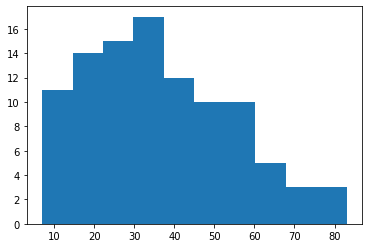

In [20]:
#inputs = lentok(beam_cands[0]['ref'])
def get_len_distr(cands):
    maxlen = 0
    totlen = 0
    vals = []
    for c in cands:
        try:
            tmp = len(lentok(c['ref'])['input_ids'])
        except:
            print("issue")
            tmp = maxlen
        maxlen = max(maxlen, tmp)
        totlen+=tmp
        vals.append(tmp)
    return vals
        
len_dist = get_len_distr(lat_cands[:100])
plt.hist(len_dist)

In [5]:
def debug_cand(ind):

    print(cand_data[ind]['ref'])
    for c in cand_data[ind]['cands']:
        print(c)
        
def find_common(c1, c2list):
    for c in c2list:
        if c['ref']==c1['ref']:
            return c
        
def get_cometqe_scores(hyps, srcs):
    cometqe_input = [{"src": src, "mt": mt} for src, mt in zip(srcs, hyps)]
    # sentence-level and corpus-level COMET
    outputs = model.predict(
        cometqe_input, batch_size=40, progress_bar=True
    )
    torch.cuda.empty_cache()
    return outputs

def get_comet_scores(hyps, srcs, refs):
    cometqe_input = [{"src": src, "mt": mt, "ref":ref} for src, mt, ref in zip(srcs, hyps, refs)]
    # sentence-level and corpus-level COMET
    outputs = comet.predict(
        cometqe_input, batch_size=40, progress_bar=True
    )
    torch.cuda.empty_cache()
    return outputs

def test_cometqe(hyp, src):
    cqe_input = [{'src':src, 'mt':hyp}]
    outputs = model.predict(
        cqe_input, batch_size=1, progress_bar=True
    )
    torch.cuda.empty_cache()
    return outputs

In [4]:
#print(beam_cands[0]['cands'][0])
def comp_debug_cand(ind, k):
    if len(lat_cands[ind]['cands'])==0:
        return
    print("INPUT")
    print(lat_cands[ind]['inp'])
    print("REF")
    print(lat_cands[ind]['ref'])
    print("LATTICE")
    for i in range(0, k):
        try:
            print(lat_cands[ind]['scores'][i])
            print(lat_cands[ind]['cands'][i])
        except:
            #print("NONE")
            ""
    print("BEAM")
    common = find_common(lat_cands[ind], beam_cands)
    #print(common)
    for i in range(0, k):
        print(common['scores'][i])
        print(common['cands'][i])
    print("BEAM")
    print(get_comet_scores([common['cands'][0]], [lat_cands[ind]['inp']], [lat_cands[ind]['ref']]))
    print("LATTICE")
    print(get_comet_scores([lat_cands[ind]['cands'][0]], [lat_cands[ind]['inp']], [lat_cands[ind]['ref']]))

for i in range(1, 20):
    comp_debug_cand(i, 5)

NameError: name 'lat_cands' is not defined

In [7]:
comet_path = download_model(cometmodel, "./cometmodel")
comet = load_from_checkpoint(comet_path)

wmt20-comet-da is already in cache.
Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaModel: ['roberta.pooler.dense.weight', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Encoder model frozen.


In [6]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

device = "cuda:3" if torch.cuda.is_available() else "cpu"


tokenizer = AutoTokenizer.from_pretrained("facebook/mbart-large-50-one-to-many-mmt", src_lang="en_XX", tgt_lang="de_DE")
model = AutoModelForSeq2SeqLM.from_pretrained("facebook/mbart-large-50-one-to-many-mmt")
model.to(device)
print("")

In [46]:
del tokenizer
del model

In [9]:
# TODO (print lengths, track throughout pipeline)

def get_mbart_nll(cand, ind, tok, mod):

    inp = cand['inp']
    out = cand['cands'][ind]
    print(out)

    inputs = tokenizer(inp).to(device)
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(out, return_tensors="pt").to(device)

    # forward pass
    output = model(**inputs, labels=labels.input_ids)
    #print(type(labels))
    #print(labels.attention_mask)
    return output.loss

def test_cand(cand, ind):
    print(get_mbart_nll(cand, ind))
    print(cand['scores'][ind])
    
def rescore_cands(c_list):
    device = "cuda:3" if torch.cuda.is_available() else "cpu"
    mname = "facebook/mbart-large-50-one-to-many-mmt"
    src_l = "en_XX"
    tgt_l = "de_DE"
    tok = tokenizer
    mod = model
    # tok = AutoTokenizer.from_pretrained(mname, src_lang=src_l, tgt_lang=tgt_l)
    # mod = AutoModelForSeq2SeqLM.from_pretrained(mname)
    # mod.to(device)
    i = 0
    for c in c_list:
        c['oldsco'] = c['scores']
        c['scores'] = []
        for can in range(0, len(c['cands'])):
            c['scores'].append(float(get_mbart_nll(c, can, tok, mod)))
        c['sco_ranks'] = list(numpy.argsort(c['scores']))
        print(i)
        i+=1
    # del tok
    # del mod
    return c_list
        

In [10]:
get_mbart_nll(lat_cands[0], 0, tokenizer, model)

Wenn es jedoch um terroristische Aktivitäten geht, sind solche Linien schwer zu ziehen.


AttributeError: 'list' object has no attribute 'to'

In [ ]:
resc

In [44]:
lat_cands[0]['scores'][0]

In [57]:
type(model)

transformers.models.mbart.modeling_mbart.MBartForConditionalGeneration

In [4]:
# Scoring Sanity Check
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("facebook/mbart-large-50-one-to-many-mmt")
mname = "facebook/mbart-large-50-one-to-many-mmt"
src_l = "en_XX"
tgt_l = "de_DE"
tok = AutoTokenizer.from_pretrained(mname, src_lang=src_l, tgt_lang=tgt_l)
model = AutoModelForSeq2SeqLM.from_pretrained("facebook/mbart-large-50-one-to-many-mmt")
model.to("cuda:3")

In [6]:
sampinp = ["Technically speaking, the central pillar of the new debt agreement is a decade-long postponement of payments totaling 96.6 billion ($112.5 billion) that were due to begin in 2023."]

In [8]:
inps = tokenizer(sampinp, return_tensors="pt").to("cuda:3")
out = model.generate(
    **inps,
    forced_bos_token_id=tokenizer.lang_code_to_id["de_DE"],
    num_beams=50,
    max_length=70, 
    num_return_sequences=50,
    return_dict_in_generate=True,
    output_scores=True,
)
cands = tokenizer.batch_decode(out.sequences, skip_special_tokens=True)

In [9]:
out.sequences_scores

tensor([-0.3065, -0.3084, -0.3094, -0.3126, -0.3160, -0.3175, -0.3182, -0.3198,
        -0.3201, -0.3204, -0.3221, -0.3223, -0.3232, -0.3241, -0.3243, -0.3246,
        -0.3254, -0.3256, -0.3258, -0.3272, -0.3283, -0.3297, -0.3309, -0.3315,
        -0.3322, -0.3322, -0.3327, -0.3339, -0.3341, -0.3342, -0.3343, -0.3352,
        -0.3356, -0.3360, -0.3362, -0.3366, -0.3373, -0.3377, -0.3391, -0.3392,
        -0.3399, -0.3402, -0.3409, -0.3411, -0.3418, -0.3422, -0.3430, -0.3437,
        -0.3444, -0.3450], device='cuda:3')

In [59]:
# inputs = tok(sampinp[0], return_tensors="pt").to("cuda:3")
inputs = tokenizer(sampinp, return_tensors="pt").to("cuda:3")
with tok.as_target_tokenizer():
    labels = tok(cands[0], return_tensors="pt").to("cuda:3")

# forward pass
output = model(**inputs, labels=tmp)
print(output.loss)

AttributeError: 'list' object has no attribute 'to'

In [42]:
print(out.sequences[:1])
print(labels.input_ids)
#print(inputs['input_ids'][0]) 
#print(inps['input_ids'][0])

tensor([[     2, 250004,  92265,  35206,     47,  34784,  89024,    133,   5204,
         132756,      7,   2750,   6777,    959,   1380,    678,  18912,  13133,
           2258,      7,      2,      1,      1,      1,      1,      1,      1]],
       device='cuda:3')
tensor([[250004,  92265,  35206,     47,  34784,  89024,    133,   5204, 132756,
              7,   2750,   6777,    959,   1380,    678,  18912,  13133,   2258,
              7,      2]], device='cuda:3')


In [58]:
tmp = torch.cat((torch.tensor([2]).to("cuda:3"), labels.input_ids[0]))
tmp = torch.cat((tmp, (torch.tensor([2]).to("cuda:3"))))

tmp = torch.unsqueeze(tmp, dim=0)

In [20]:
#
scores = [-0.4911, -0.4951, -0.4967, -0.5049, -0.5070, -0.5218, -0.5272, -0.5327,
        -0.5333, -0.5343, -0.5345, -0.5355, -0.5382, -0.5382, -0.5386, -0.5387,
        -0.5411, -0.5471, -0.5476, -0.5504, -0.5519, -0.5520, -0.5535, -0.5552,
        -0.5554, -0.5561, -0.5561, -0.5618, -0.5642, -0.5644, -0.5662, -0.5685,
        -0.5685, -0.5689, -0.5690, -0.5698, -0.5714, -0.5749, -0.5754, -0.5756,
        -0.5766, -0.5771, -0.5787, -0.5791, -0.5797, -0.5816, -0.5856, -0.5872,
        -0.5873, -0.5873]
cands = ['French police to arrest Anderlecht supporters who did not come with RSCA cars.',
 '</s>en_XX The French police will arrest supporters of Anderlecht who came otherwise than with the cars of the RSCA</s><pad>',
 '</s>en_XX French police to arrest Anderlecht supporters who came otherwise than with RSCA cars</s><pad><pad><pad><pad><pad><pad>',
 '</s>en_XX French police to arrest Anderlecht supporters who came otherwise than with the RSCA cars</s><pad><pad><pad><pad><pad>',
 '</s>en_XX French police to arrest Anderlecht supporters who did not come with the RSCA cars</s><pad><pad><pad><pad><pad>',
 '</s>en_XX French police to arrest Anderlecht supporters who did not come with RSCA buses</s><pad><pad><pad><pad><pad><pad>',
 '</s>en_XX French police to arrest Anderlecht supporters who came otherwise than in RSCA cars</s><pad><pad><pad><pad><pad><pad>',
 '</s>en_XX French police to arrest Anderlecht supporters who came otherwise than on RSCA buses</s><pad><pad><pad><pad><pad><pad>',
 '</s>en_XX The French police will arrest supporters of Anderlecht who have come otherwise than with the cars of the RSCA</s>',
 '</s>en_XX French police to arrest Anderlecht supporters who came in other than RSCA cars</s><pad><pad><pad><pad><pad><pad>',
 '</s>en_XX French police to arrest Anderlecht supporters not using RSCA cars</s><pad><pad><pad><pad><pad><pad><pad><pad><pad>',
 '</s>en_XX French police to arrest Anderlecht supporters who did not travel with RSCA cars</s><pad><pad><pad><pad><pad><pad>',
 '</s>en_XX French police will arrest supporters of Anderlecht who came otherwise than with the RSCA cars</s><pad><pad><pad><pad>',
 '</s>en_XX French police to arrest Anderlecht supporters who came otherwise than with RSCA buses</s><pad><pad><pad><pad><pad><pad>',
 '</s>en_XX French police will arrest Anderlecht supporters who came otherwise than with the RSCA cars</s><pad><pad><pad><pad><pad>',
 '</s>en_XX French police to arrest supporters of Anderlecht who came otherwise than with the RSCA cars</s><pad><pad><pad><pad>',
 '</s>en_XX French police to arrest supporters of Anderlecht who came otherwise than with RSCA cars</s><pad><pad><pad><pad><pad>',
 '</s>en_XX French police to arrest Anderlecht supporters who did not come with the RSCA buses</s><pad><pad><pad><pad><pad>',
 '</s>en_XX French police to arrest Anderlecht supporters not travelling with RSCA cars</s><pad><pad><pad><pad><pad><pad><pad>',
 '</s>en_XX The French police will arrest supporters of Anderlecht who came otherwise than with the RSCA cars</s><pad><pad><pad>',
 '</s>en_XX French police to arrest Anderlecht supporters who did not travel with the RSCA cars</s><pad><pad><pad><pad><pad>',
 '</s>en_XX French police will arrest Anderlecht supporters who did not come with the RSCA cars</s><pad><pad><pad><pad><pad>',
 "</s>en_XX French police to arrest Anderlecht supporters who didn't come with RSCA cars</s><pad><pad><pad><pad><pad>",
 '</s>en_XX French police to arrest Anderlecht supporters who came otherwise than with the RSCA buses</s><pad><pad><pad><pad><pad>',
 '</s>en_XX French police to arrest Anderlecht supporters who did not travel with RSCA buses</s><pad><pad><pad><pad><pad><pad>',
 '</s>en_XX French police to arrest Anderlecht supporters who do not come with RSCA cars</s><pad><pad><pad><pad><pad><pad>',
 '</s>en_XX French police to arrest Anderlecht supporters who came otherwise than by RSCA bus</s><pad><pad><pad><pad><pad><pad><pad>',
 '</s>en_XX French police will arrest supporters of Anderlecht who came otherwise than with RSCA cars</s><pad><pad><pad><pad><pad>',
 '</s>en_XX French police to arrest Anderlecht supporters who came otherwise than from RSCA cars</s><pad><pad><pad><pad><pad><pad>',
 "</s>en_XX French police to arrest Anderlecht supporters who didn't come with the RSCA cars</s><pad><pad><pad><pad>",
 '</s>en_XX The French police will arrest supporters of Anderlecht who came otherwise than with the cars of the RSCA.</s>',
 '</s>en_XX French police to arrest Anderlecht supporters who came otherwise than by RSCA cars</s><pad><pad><pad><pad><pad><pad>',
 '</s>en_XX French police to arrest Anderlecht supporters who have come otherwise than with RSCA cars</s><pad><pad><pad><pad><pad>',
 '</s>en_XX French police to arrest Anderlecht supporters who came otherwise than on RSCA cars</s><pad><pad><pad><pad><pad><pad>',
 '</s>en_XX French police to arrest Anderlecht supporters who come otherwise than with the RSCA cars</s><pad><pad><pad><pad><pad>',
 '</s>en_XX French police to arrest Anderlecht supporters not travelling with RSCA buses</s><pad><pad><pad><pad><pad><pad><pad>',
 '</s>en_XX French police to arrest supporters of Anderlecht who did not come with RSCA cars</s><pad><pad><pad><pad><pad>',
 '</s>en_XX French police to arrest Anderlecht supporters who have come otherwise than with the RSCA cars</s><pad><pad><pad><pad>',
 '</s>en_XX French police to arrest supporters of Anderlecht who did not come with the RSCA cars</s><pad><pad><pad><pad>',
 '</s>en_XX French police to arrest Anderlecht supporters who didn’t come with RSCA cars</s><pad><pad><pad><pad><pad>',
 '</s>en_XX French police to arrest Anderlecht supporters who came in other than RSCA buses</s><pad><pad><pad><pad><pad><pad>',
 '</s>en_XX French police to arrest Anderlecht supporters who came otherwise than by RSCA car</s><pad><pad><pad><pad><pad><pad><pad>',
 '</s>en_XX French police will arrest supporters of Anderlecht who come otherwise than with the RSCA cars</s><pad><pad><pad><pad>',
 "</s>en_XX French police to arrest Anderlecht supporters who didn't come with RSCA buses</s><pad><pad><pad><pad><pad>",
 '</s>en_XX French police to arrest Anderlecht supporters who did not travel with the RSCA buses</s><pad><pad><pad><pad><pad>',
 '</s>en_XX French police to arrest Anderlecht supporters who came otherwise than in the RSCA cars</s><pad><pad><pad><pad><pad>',
 '</s>en_XX French police to arrest Anderlecht supporters who didn’t come with the RSCA cars</s><pad><pad><pad><pad>',
 '</s>en_XX French police to arrest Anderlecht supporters who do not come with RSCA buses</s><pad><pad><pad><pad><pad><pad>',
 '</s>en_XX The French police will arrest supporters of Anderlecht who have come otherwise than with the RSCA cars</s><pad><pad>',
 '</s>en_XX The French police will arrest supporters of Anderlecht who came otherwise than with the cars of RSCA</s><pad><pad>']

In [36]:
#s[0] = out.sequences[0]
output = model(**inputs, labels=out.sequences[:1])
print(output.loss)

tensor(3.6970, device='cuda:3', grad_fn=<NllLossBackward0>)


In [30]:
s = torch.tensor([])

In [25]:
# recreating rescore code


In [26]:
output.loss

tensor(0.7188, device='cuda:3', grad_fn=<NllLossBackward0>)

In [29]:
import torch